# Plant Disease Detection using Transfer Learning (EfficientNet)

This notebook demonstrates how to use transfer learning with EfficientNet to classify plant diseases based on images.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Check TensorFlow version
print(f'TensorFlow Version: {tf.__version__}')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow Version: 2.13.0


## 1. Load and Preprocess Dataset

In [2]:
train_dir = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_dir = '../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

img_height, img_width = 256, 256
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


for data_batch, labels_batch in train_data:
    print(data_batch.shape, labels_batch.shape)
    break

Found 70295 images belonging to 38 classes.
Found 70295 images belonging to 38 classes.
(32, 256, 256, 3) (32, 38)


## 2. Build the Model using EfficientNet

In [3]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

print(f"Train data classes: {train_data.num_classes}")

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

## 3. Train the Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

class BatchValidationCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(f" Step {batch + 1}: Train Accuracy = {logs['accuracy']:.4f}")
    
    def on_test_batch_end(self, batch, logs=None):
        print(f" Validation Step {batch + 1}: Validation Accuracy = {logs['accuracy']:.4f}")


log_batch_metrics = BatchValidationCallback()


# somehow I have managed to get the model to not just overfit but be the best
# parrot the living has ever seen so much so that saying it overfitted would be
# disrespectful to all overfitted models out there
try:
    history = model.fit_generator(
        train_data,
        validation_data=val_data,
        epochs=5,
        callbacks=[early_stopping, checkpoint, log_batch_metrics],
        verbose=1
    )
except Exception as e:
    print(f"Error during training: {e}")

/tmp/ipykernel_42/3423135365.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5


2024-12-07 19:50:08.664718: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 Step 1: Train Accuracy = 0.1250
2197/2197 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9357 Validation Step 1: Validation Accuracy = 0.0625
 Validation Step 2: Validation Accuracy = 0.0469
 Validation Step 3: Validation Accuracy = 0.0312
 Validation Step 4: Validation Accuracy = 0.0234
 Validation Step 5: Validation Accuracy = 0.0250
 Validation Step 6: Validation Accuracy = 0.0312
 Validation Step 7: Validation Accuracy = 0.0312
 Validation Step 8: Validation Accuracy = 0.0273
 Validation Step 9: Validation Accuracy = 0.0243
 Validation Step 10: Validation Accuracy = 0.0250
 Validation Step 11: Validation Accuracy = 0.0227
 Validation Step 12: Validation Accuracy = 0.0234
 Validation Step 13: Validation Accuracy = 0.0216
 Validation Step 14: Validation Accuracy = 0.0223
 Validation Step 15: Validation Accuracy = 0.0250
 Validation Step 16: Validation Accuracy = 0.0273
 Validation Step 17: Validation Accuracy = 0.0276
 Validation Step 18: Validation Accuracy

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2197/2197 [==============================] - 1571s 697ms/step - loss: 0.2142 - accuracy: 0.9357 - val_loss: 7.5441 - val_accuracy: 0.0273
Epoch 2/5
 Step 1: Train Accuracy = 0.9688
2197/2197 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9739 Validation Step 1: Validation Accuracy = 0.0938
 Validation Step 2: Validation Accuracy = 0.0625
 Validation Step 3: Validation Accuracy = 0.0417
 Validation Step 4: Validation Accuracy = 0.0391
 Validation Step 5: Validation Accuracy = 0.0375
 Validation Step 6: Validation Accuracy = 0.0417
 Validation Step 7: Validation Accuracy = 0.0357
 Validation Step 8: Validation Accuracy = 0.0352
 Validation Step 9: Validation Accuracy = 0.0347
 Validation Step 10: Validation Accuracy = 0.0312
 Validation Step 11: Validation Accuracy = 0.0398
 Validation Step 12: Validation Accuracy = 0.0443
 Validation Step 13: Validation Accuracy = 0.0433
 Validation Step 14: Validation Accuracy = 0.0424
 Validation Step 15: Validation Accuracy =

## 4. Evaluate the Model

2197/2197 [==============================] - 184s 84ms/step - loss: 13.5452 - accuracy: 0.0229
Validation Loss: 13.545222282409668
Validation Accuracy: 0.022875025868415833


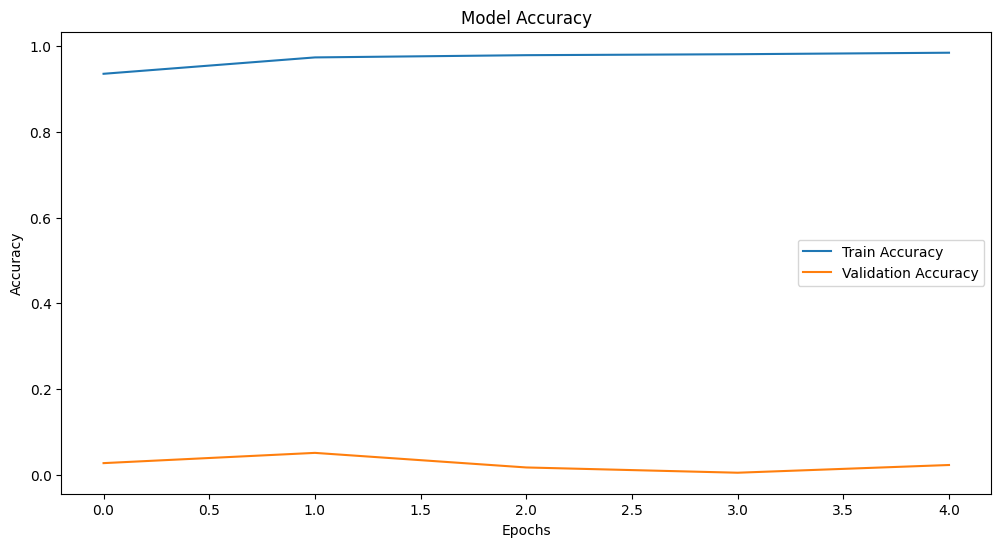

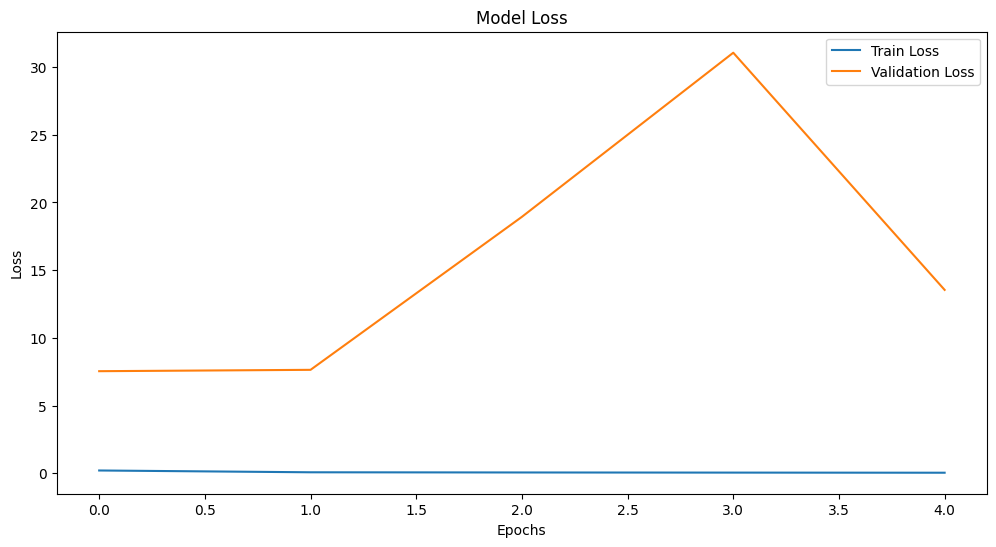

In [5]:
val_loss, val_acc = model.evaluate(val_data)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()